In [2]:
from glob import glob

In [3]:
m1 = glob('data/xrd_data/*1min*')
m2 = glob('data/xrd_data/*2min*')
m4 = glob('data/xrd_data/*4min*')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def load_one(path):
    return pd.read_csv(path).set_index('2theta')

In [6]:
df_m1 = pd.concat([load_one(p) for p in m1], axis = 1)
df_m2 = pd.concat([load_one(p) for p in m2], axis = 1)
df_m4 = pd.concat([load_one(p) for p in m4], axis = 1)

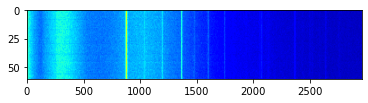

In [7]:
plt.imshow(df_m2.values.T, aspect = 10, cmap = 'jet')

In [8]:
patterns = df_m4.values.T

In [9]:
from xrdc import source_separation as sep

In [10]:
threshold = 20
bg_smooth = 20
bg_smooth_post = 20


background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = False,
                                 threshold = threshold, smooth_q = 1.7, smooth_neighbor_background = 0,
                                smooth_q_background = bg_smooth,
                                 bg_fill_method = 'simple')

(0, 0)


In [11]:
agged_background = np.mean(background, axis = 0)

background_variation = background - np.mean(background, axis = 0)

In [12]:
%matplotlib inline
sep.iplot_rows(patterns, background)

interactive(children=(IntSlider(value=29, description='i', max=59), Output(layout=Layout(height='550px'))), _d…

In [13]:
from xrdc.source_separation import gf

from sklearn.utils import resample

from scipy.stats import kstest

In [14]:
import slide_tricks as st

In [15]:
from xrdc import fourier
from xrdc import featurization as feat

In [16]:
%matplotlib inline

In [17]:
from scipy.signal import peak_widths as pw, find_peaks

In [18]:
sig = 2.5
# area= np.sqrt(2 * np.pi * sig**2)

In [19]:
integration_scale = 2 * np.pi * 2.35 * sig / 2

(60, 2962)
(2962,) (60, 2962)


(0.0, 2962.0)

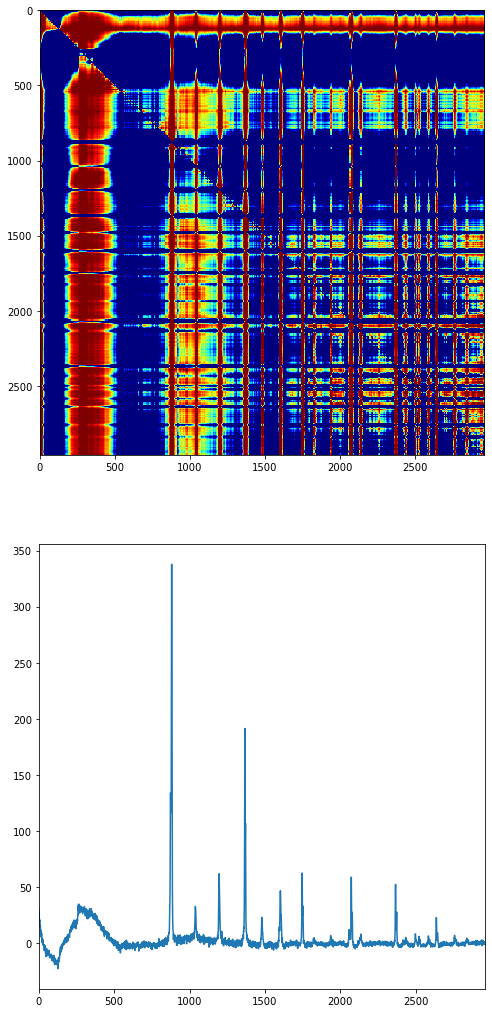

In [20]:
peak = fourier.lowpass_g(100, patterns[0])
#peak = peak / peak.sum()

def mk_blocks_agg(arr):
    return st.sliding_window_view(arr, (len(arr), 7)).squeeze()[::7].mean(axis = 2)


def agg_2d(patterns):
    agged_2d = st.sliding_window_view(patterns, (len(patterns), 7)).squeeze().mean(axis = 2).T
    agged_2d = np.pad(agged_2d, ((0,), (3,)), mode = 'edge')
    return agged_2d


def conv2d(a, b):
    return a
    return np.vstack([np.convolve(p, b, 'same') for p in a])


import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(8, 18)

#agged_det = agg_2d((fast_q - background_variation)[:30])

def compute_zscores(subsample = 1):
    sig = np.sqrt((peak.sum()**2) / (2 * np.pi))
    sig_int = int(sig)


    det = fast_q - background_variation
    det = gf(det, sig) * integration_scale


    print(det.shape)
    det = det[::subsample]
    pdeak = peak[::subsample]

    block_means = np.mean(conv2d(det, peak), axis = 0)#.mean(axis = 0)#mk_blocks_agg(agged_det).mean(axis = 1)
    print(block_means.shape, det.shape)
    #block_stds = np.median(np.sqrt((conv2d(det, peak) - block_means)**2), axis = 0)

    b = block_means.reshape((block_means.shape[0], 1))

    pairwise_diffs = block_means - b

    # pairwise_stds = np.sqrt(block_stds**2 + block_stds.reshape((block_stds.shape[0], 1))**2)
    pairwise_stds =  feat.l2_pairs(conv2d(det, peak).T)

    ratio = integration_scale * pairwise_diffs / (pairwise_stds + 1e-9)
    ratio = gf(ratio, (0, 0))
    #ratio = gf(ratio, (3, 0)) * sig
    return pairwise_diffs, pairwise_stds, ratio

#     independent_stride = 10

def get_aggregate_zscores(subsample = 1, independent_stride = 10):
    pairwise_diffs, pairwise_stds, ratio = compute_zscores(subsample)
    rowmask = (np.median(fast_q, axis = 0) < np.percentile(np.median(fast_q, axis = 0), 50))
    rowmask[:1300] = False

    imask = np.arange(len(ratio))[rowmask]

    std_agg_ratio = pairwise_diffs[imask][::independent_stride].sum(axis = 0) /\
        np.sqrt((pairwise_stds[imask][::independent_stride]**2).sum(axis = 0))
    return std_agg_ratio

pairwise_diffs, pairwise_stds, ratio = compute_zscores(1)

a,b  = 2, 1
plt.subplot(a,b, 1)
plt.imshow(
    ((ratio)),
    cmap = 'jet', vmax = 2, vmin = 0, interpolation = 'none')
#plt.colorbar()

plt.subplot(a,b, 2)
plt.plot(fast_q.mean(axis = 0))
plt.xlim(0, len(patterns[0]))

In [21]:
subsample = 1

In [22]:
sig = np.sqrt((peak.sum()**2) / (2 * np.pi))
sig_int = int(sig)


det = fast_q - background_variation
det = gf(det, sig) * integration_scale


print(det.shape)
det = det[::subsample]
pdeak = peak[::subsample]

block_means = np.mean(conv2d(det, peak), axis = 0)#.mean(axis = 0)#mk_blocks_agg(agged_det).mean(axis = 1)
print(block_means.shape, det.shape)
#block_stds = np.median(np.sqrt((conv2d(det, peak) - block_means)**2), axis = 0)

b = block_means.reshape((block_means.shape[0], 1))

pairwise_diffs = block_means - b

# pairwise_stds = np.sqrt(block_stds**2 + block_stds.reshape((block_stds.shape[0], 1))**2)
pairwise_stds =  feat.l2_pairs(conv2d(det, peak).T)

ratio = integration_scale * pairwise_diffs / (pairwise_stds + 1e-9)
ratio = gf(ratio, (0, 0))
#ratio = gf(ratio, (3, 0)) * sig

(60, 2962)
(2962,) (60, 2962)


In [23]:
independent_stride = 10

In [183]:
def mk_pairs_mask(arr):
    """
    Select which q points count as background, then return a corresponding square boolean matrix
    """
    rowmask = (arr < np.percentile(arr, 50))
    #rowmask[:1300] = False

    pairs_mask = np.einsum('i,j->ij', rowmask, rowmask)
    return pairs_mask

In [30]:
from sklearn.utils import resample

In [34]:
def resample_2d(arr):
    N = len(arr)
    idx = np.arange(N).astype(int)
    return arr[resample(idx), :]

In [35]:
def boot_stderr(arr2d):
    return np.vstack([resample_2d(arr2d).mean(axis = 0) for _ in range(100)]).std(axis = 0)

In [125]:
def c2d(arr, kernel):
    arr_conv = np.vstack([np.convolve(p, kernel, 'same') for p in arr])
    idxs = np.arange(len(arr[0]))
    return idxs, arr_conv

def get_aggregate_mean(arr, kernel, stride):
    idxs, arr_conv = c2d(arr, kernel)
    return idxs[::stride], np.mean(arr_conv[:, ::stride], axis = 0)

def get_aggregate_std(arr, kernel, stride):
    arr_conv = np.vstack([np.convolve(p, kernel, 'same') for p in arr])
    idxs = np.arange(len(arr))
    return idxs[::stride], np.std(arr_conv[:, ::stride], axis = 0)

def get_aggregate_stderr(arr, kernel, stride):
    idxs, arr_conv = c2d(arr, kernel)
    return idxs[::stride], arr_conv[:, ::stride], arr_conv[:, ::stride].mean(axis = 0), boot_stderr(arr_conv[:, ::stride])

In [238]:
_, agged, mean, sterr = get_aggregate_stderr(fast_q, peak, 10)
zscores = (np.abs(cartesian_diff(mean, mean)) / (cartesian_quad(sterr, sterr) + 1e-9))

In [239]:
# _, agged, mean, sterr = get_aggregate_stderr(patterns, peak, 10)
# zscores = (np.abs(cartesian_diff(mean, mean)) / (cartesian_quad(sterr, sterr) + 1e-9))

In [240]:
def cartesian_quad(a, b):
    b = b.reshape((b.shape[0], 1))
    return np.sqrt(a**2 + b**2)

def cartesian_diff(a, b):
    b = b.reshape((b.shape[0], 1))
    return b - a



<IPython.core.display.Javascript object>


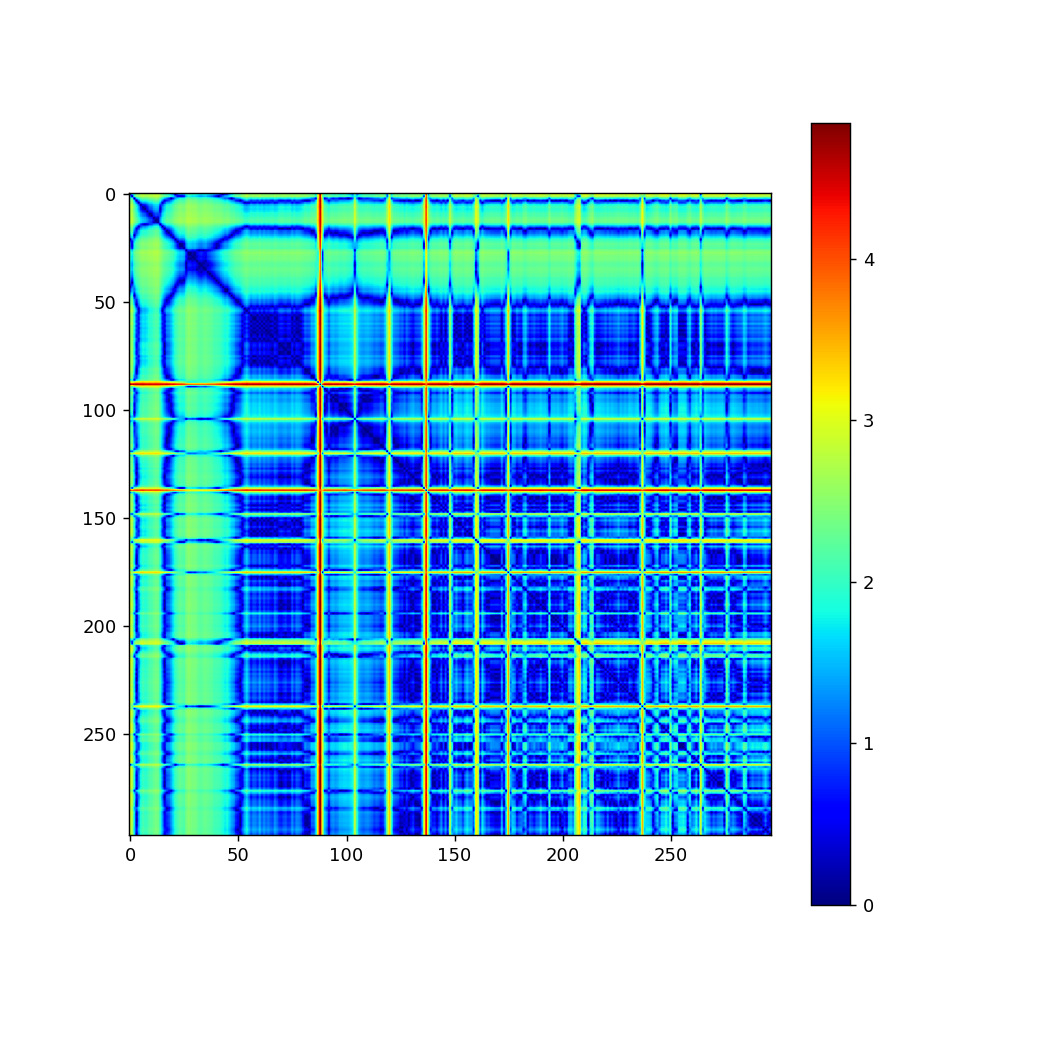

In [241]:
plt.imshow(np.log(1 + zscores), cmap = 'jet')
plt.colorbar()

<IPython.core.display.Javascript object>


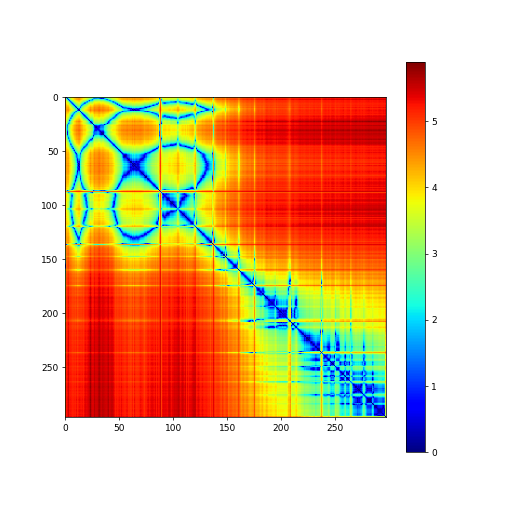

In [231]:
plt.imshow(np.log(1 + zscores), cmap = 'jet')
plt.colorbar()

In [116]:
stride = 10

In [161]:
from scipy.stats import pearsonr

In [174]:
mpl.rcParams['figure.figsize'] =(16, 8)

In [235]:
pairs_mask = mk_pairs_mask(np.median(zscores_f, axis = 0))

<IPython.core.display.Javascript object>


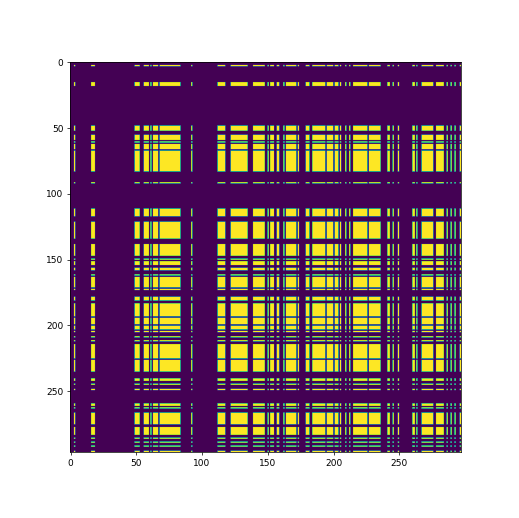

In [236]:
plt.imshow(pairs_mask)

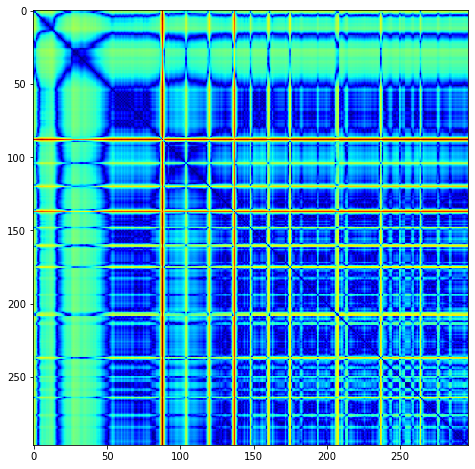

In [193]:
plt.imshow(np.log(1 + zscores), cmap = 'jet')

In [195]:
(pairs_mask * zscores)

3.103611687997268

In [200]:
np.log(2)

0.6931471805599453

In [ ]:
np.lo

In [204]:
plt.hlines?

(60, 2962)
(2962,) (6, 2962)


<IPython.core.display.Javascript object>


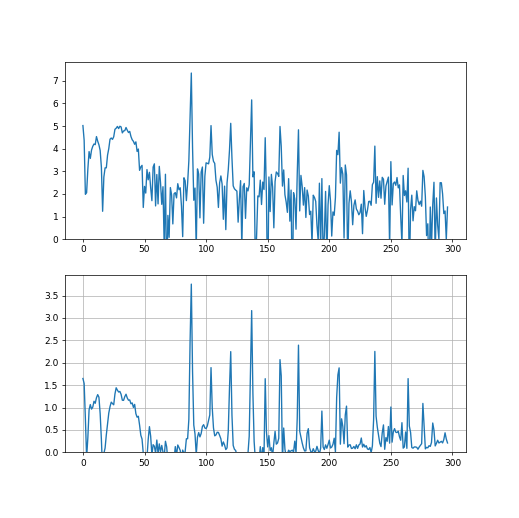

In [226]:
%matplotlib notebook

a, b = 2, 1

std_agg_ratio = get_aggregate_zscores(10, 10)
skip = 5
mpl.rcParams['figure.figsize'] =(8, 8)
plt.subplot(a, b, 1)
#plt.plot(100 * fast_q.mean(axis = 0) / 20)
plt.grid()
plt.plot(np.log(np.abs(100 * fast_q.mean(axis = 0) / 20))[::stride])
plt.grid()
plt.ylim(0, None)

plt.subplot(a, b, 2)
plt.plot(
    gf((
        np.log(1 + np.median(zscores, axis = 0))) - 1
        , 0)
)
plt.ylim(0., None)
plt.grid()

In [25]:
pairwise_diffs, pairwise_stds, ratio = compute_zscores(subsample)
rowmask = (np.median(fast_q, axis = 0) < np.percentile(np.median(fast_q, axis = 0), 50))
rowmask[:1300] = False

pairs_mask = np.einsum('i,j->ij', rowmask, rowmask)

imask = np.arange(len(ratio))[rowmask]

std_agg_ratio = pairwise_diffs[imask][::independent_stride].sum(axis = 0) /\
    np.sqrt((pairwise_stds[imask][::independent_stride]**2).sum(axis = 0))

(60, 2962)
(2962,) (60, 2962)


In [95]:
tmp = feat.l2_pairs(det.T)

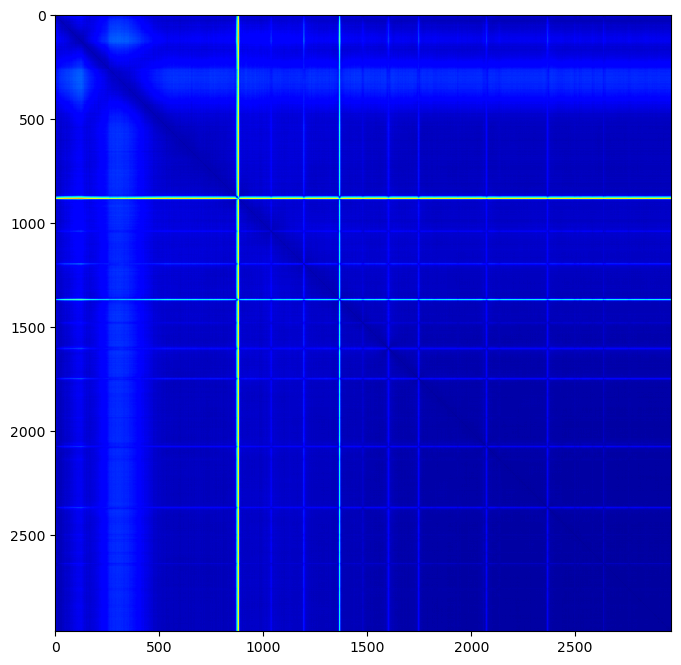

In [99]:
%matplotlib inline
plt.imshow(tmp, cmap = 'jet')

In [ ]:
# rowmask = (np.median(fast_q, axis = 0) < np.percentile(np.median(fast_q, axis = 0), 50))
# rowmask[:1300] = False

# imask = np.arange(len(ratio))[rowmask]

<IPython.core.display.Javascript object>


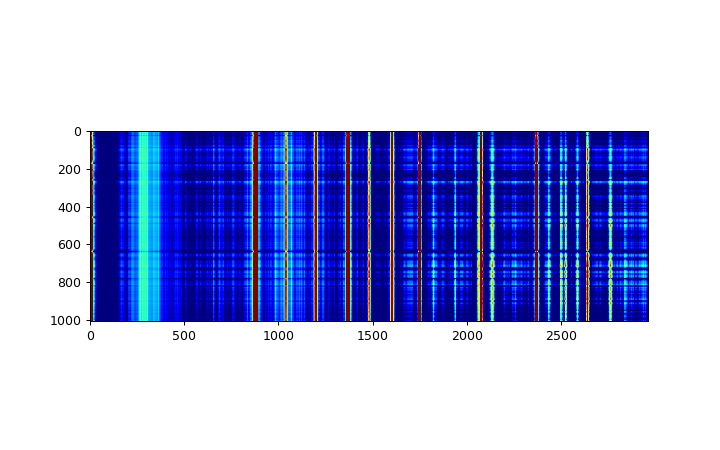

In [33]:
mpl.rcParams['figure.figsize'] =(8, 5)

plt.imshow(ratio[imask, :], cmap = 'jet', aspect = 1, vmin = 0, vmax = 2, interpolation = 'none')

<IPython.core.display.Javascript object>


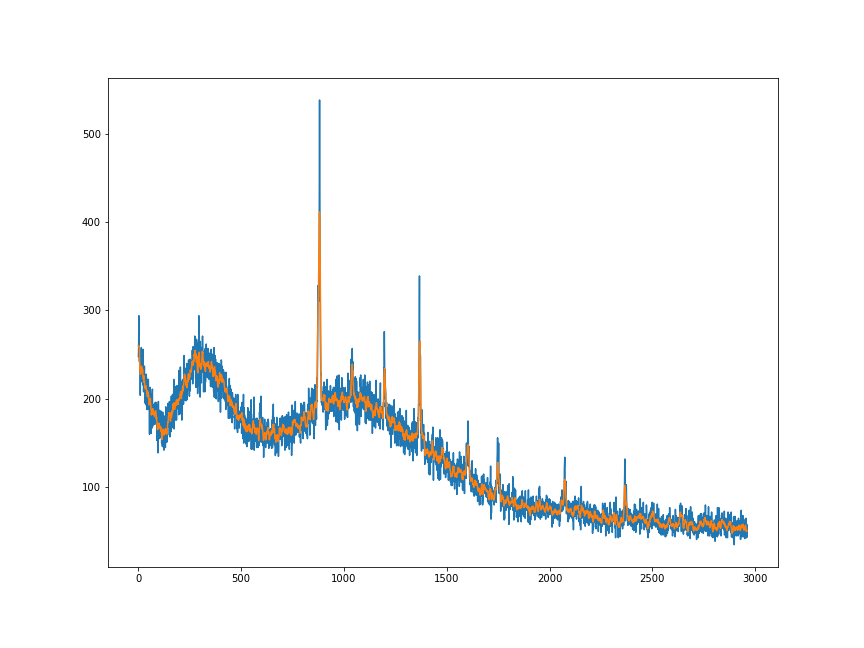

In [119]:
%matplotlib notebook
i = 10
plt.plot(patterns[i])
plt.plot(agged_2d[i])

In [49]:
def resample_2d(arr):
    N = len(arr)
    idx = np.arange(N).astype(int)
    return arr[resample(idx), :]
    

<IPython.core.display.Javascript object>


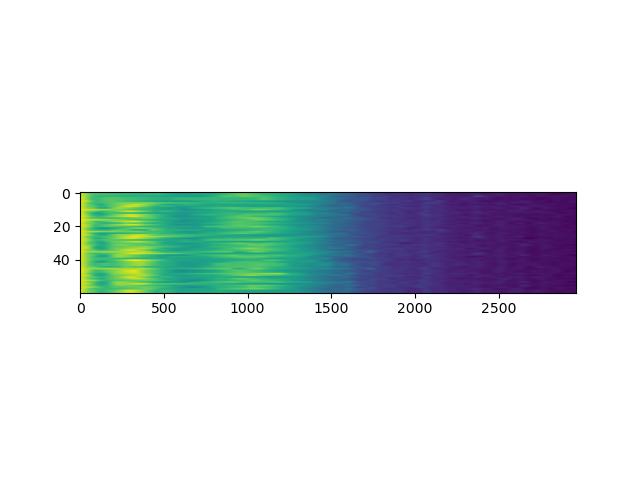

In [56]:
plt.imshow(resample_2d(background), aspect = 10)

In [46]:
N = len(patterns)
aggregate_uncertainty = np.sqrt((fast_T.std(axis = 0)**2 + background.std(axis = 0)**2) / N)
background = gf(background, (0, bg_smooth_post))
aggregate_uncertainty = gf(aggregate_uncertainty, bg_smooth_post)